**Main imports**

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

**Import dataset**

In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

Files already downloaded and verified
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

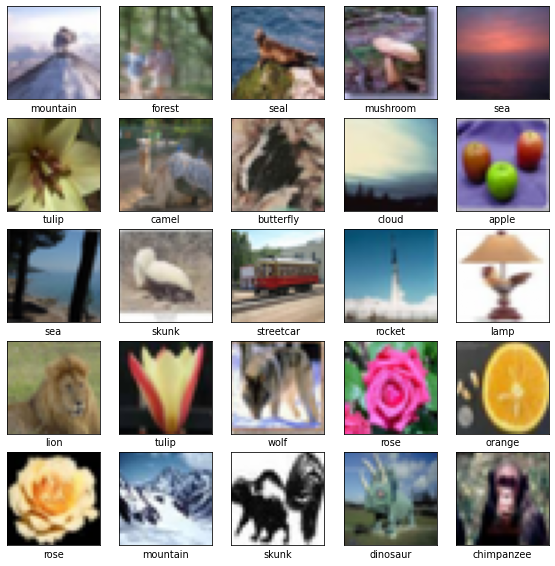

In [3]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

**Model for SmallFilternsCNN approach with reduced filter size**

In [4]:
# Define the SmallFiltersCNN model with reduced filter size
class SmallFiltersCNN(nn.Module):
    def __init__(self, params):
        super(SmallFiltersCNN, self).__init__()
        self.conv1 = nn.Conv2d(params['n_channels'], 8, kernel_size=3, padding=1)  # Reduce number of filters to 8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)  # Reduce number of filters to 16
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Reduce number of filters to 32
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, params['n_classes'])  # Adjusted based on CIFAR-100 input size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)  # Adjusted based on CIFAR-100 input size
        x = self.fc1(x)
        return x

# Hyperparameters
params = {
    'n_channels': 3,      # Number of channels
    'n_classes': 100      # Number of classes for CIFAR-100
}

# Instantiate the model
cnn_model = SmallFiltersCNN(params).to(device)

# Print the number of parameters
num_params = len(torch.nn.utils.parameters_to_vector(cnn_model.parameters()))
print(f'> Number of parameters {num_params}')

# Check if the number of parameters exceeds the budget
if num_params > 100000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# Initialize the optimizer
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Define lists to store training and testing accuracy
train_acc_list = []
test_acc_list = []

# Define the number of optimization steps
max_steps = 10000
steps = 0
plot_data = []

> Number of parameters 57332


**Main training and testing loop**

steps: 10000.00, train loss: 2.338, train acc: 0.412±0.063, test acc: 0.339±0.058


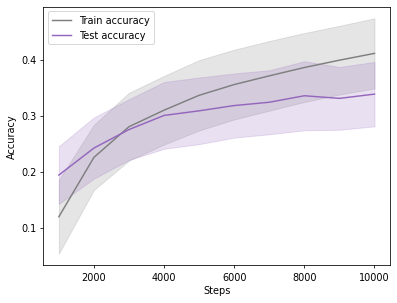

In [5]:
# Keep within our optimization step budget
while (steps < max_steps):

    # Arrays for metrics
    train_loss_arr = np.zeros(0)
    train_acc_arr = np.zeros(0)
    test_acc_arr = np.zeros(0)

    # Iterate through some of the training dataset
    for i in range(1000):
        x, t = next(train_iterator)
        x, t = x.to(device), t.to(device)

        optimizer.zero_grad()
        p = cnn_model(x)
        pred = p.argmax(dim=1, keepdim=True)
        loss = torch.nn.functional.cross_entropy(p, t)
        loss.backward()
        optimizer.step()
        steps += 1

        train_loss_arr = np.append(train_loss_arr, loss.cpu().data)
        train_acc_arr = np.append(train_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # Iterate over the entire test dataset
    for x, t in test_loader:
        x, t = x.to(device), t.to(device)
        p = cnn_model(x)
        loss = torch.nn.functional.cross_entropy(p, t)
        pred = p.argmax(dim=1, keepdim=True)
        test_acc_arr = np.append(test_acc_arr, pred.data.eq(t.view_as(pred)).float().mean().item())

    # Print loss and accuracy data
    print('steps: {:.2f}, train loss: {:.3f}, train acc: {:.3f}±{:.3f}, test acc: {:.3f}±{:.3f}'.format(
        steps, train_loss_arr.mean(), train_acc_arr.mean(), train_acc_arr.std(), test_acc_arr.mean(), test_acc_arr.std()))

    # Plot accuracy graph
    plot_data.append([steps, np.array(train_acc_arr).mean(), np.array(train_acc_arr).std(),
                      np.array(test_acc_arr).mean(), np.array(test_acc_arr).std()])
    plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey', label="Train accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data],
                     alpha=0.2, color='tab:grey')
    plt.plot([x[0] for x in plot_data], [x[3] for x in plot_data], '-', color='tab:purple', label="Test accuracy")
    plt.fill_between([x[0] for x in plot_data], [x[3]-x[4] for x in plot_data], [x[3]+x[4] for x in plot_data],
                     alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.show()
    disp.clear_output(wait=True)

**Inference on dataset**

In [ ]:
# def plot_image(i, predictions_array, true_label, img):
#     predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     img = np.transpose(img, (1, 2, 0))
#     plt.imshow(img)

#     predicted_label = np.argmax(predictions_array)
#     color = '#335599' if predicted_label == true_label else '#ee4433'

#     plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
#                                   100*np.max(predictions_array),
#                                   class_names[true_label]),
#                                   color=color)

# def plot_value_array(i, predictions_array, true_label):
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     thisplot = plt.bar(range(100), predictions_array[i], color="#777777")  # Modified to use index i
#     plt.ylim([0, 1])
#     predicted_label = np.argmax(predictions_array[i])

#     thisplot[predicted_label].set_color('#ee4433')
#     thisplot[true_label[i]].set_color('#335599')

# test_images, test_labels = next(iter(test_loader))  # Using iter() to get next batch
# test_images, test_labels = test_images.to(device), test_labels.to(device)
# test_preds = torch.softmax(cnn_model(test_images), dim=1).detach().cpu().numpy()  # Detach before numpy
# num_rows = 8
# num_cols = 4
# num_images = num_rows*num_cols
# plt.figure(figsize=(2*2*num_cols, 2*num_rows))
# for i in range(num_images):
#     plt.subplot(num_rows, 2*num_cols, 2*i+1)
#     plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
#     plt.subplot(num_rows, 2*num_cols, 2*i+2)
#     plot_value_array(i, test_preds, test_labels.cpu().numpy())  # Used .numpy() here